In [1]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from array import array
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct
import random

In [2]:
class get_mnist_data:

    def __init__(self, training_path, testing_path):
        self.train_x = self.read_images(training_path.get('images'))
        self.train_y = self.read_labels(training_path.get('labels'))

        self.test_x = self.read_images(testing_path.get('images'))
        self.test_y = self.read_labels(testing_path.get('labels'))


    def read_labels(self, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

            return labels


    def read_images(self, images_filepath):
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

            images = []
            for i in range(size):
                images.append([0] * rows * cols)
            for i in range(size):
                img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
                img = img.reshape(28, 28)
                images[i][:] = img

            return images


    def show_images(self, images, title_texts):
        cols = 5
        rows = int(len(images)/cols) + 1
        plt.figure(figsize=(30,20))
        index = 1
        for x in zip(images, title_texts):
            image = x[0]
            title_text = x[1]
            plt.subplot(rows, cols, index)
            plt.imshow(image, cmap=plt.cm.gray)
            if (title_text != ''):
                plt.title(title_text, fontsize = 15)
            index += 1


    def plot_labels(self, x, y):
        images_list = []
        titles_list = []
        for i in range(0, len(x)):
            images_list.append(x[i])
            titles_list.append('Image [' + str(i) + '] = ' + str(y[i]))

        self.show_images(images_list, titles_list)


    def filter_labels(self, labels):
        train_x = self.train_x
        train_y = self.train_y

        test_x = self.test_x
        test_y = self.test_y
        len_test = len(test_x)

        filtered_train_x = []
        filtered_train_y = []

        filtered_test_x = []
        filtered_test_y = []

        for i in range(0, len(train_x)):
            if train_y[i] in labels:
                filtered_train_x.append(train_x[i])
                filtered_train_y.append(train_y[i])

            if (i < len_test) and test_y[i] in labels:
                filtered_test_x.append(test_x[i])
                filtered_test_y.append(test_y[i])

        self.train_x = filtered_train_x
        self.train_y = filtered_train_y

        self.test_x = filtered_test_x
        self.test_y = filtered_test_y


    def preprocess_data(self, slab_config):
        train_x = self.train_x
        processed_x = []

        for i in range(0, len(train_x)):
            for k, v in slab_config:
                if i >= k[0] and ((i < k[1]) or (k[1]==-1)):
                    processed_x.append[v]

        self.train_x = processed_x


    def normalize_columns(self):
        train_df = pd.DataFrame(self.train_x)
        test_df = pd.DataFrame(self.test_x)
        columns = list(train_df)
        for c in columns:
            c = int(c)
            #print(c)
            train_df = pd.concat([train_df, pd.DataFrame(train_df[c].values.tolist()).add_prefix(f'{c}_')], axis=1).copy()
            train_df.drop(columns=[c], inplace=True)
            test_df = pd.concat([test_df, pd.DataFrame(test_df[c].values.tolist()).add_prefix(f'{c}_')], axis=1).copy()
            test_df.drop(columns=[c], inplace=True)

        self.train_df = train_df
        self.test_df = test_df


    def generate_dataframe(self):
        self.normalize_columns()
        train_df = self.train_df
        test_df = self.test_df
        #train_df = pd.DataFrame(self.train_x)
        #test_df = pd.DataFrame(self.test_x)
        
        train_df['target'] = self.train_y
        test_df['target'] = self.test_y

        return train_df, test_df

In [3]:
class classification_model:
    def __init__(self):
        self.model = None
        self.model_static_config = {
                                    'knn':KNeighborsClassifier,
                                    'DTree':DecisionTreeClassifier,
                                    'perceptron':Perceptron,
                                    'SVM':LinearSVC,
                                    'SVM_hard':LinearSVC,
                                    'kmeans':KMeans
                                   }
        self.model_type_config = 'knn'
        self.model_type = self.set_model_type()

        
    def set_model_type(self, config='knn'):
        self.model_type_config = config
        self.model_type = self.model_static_config.get(config)


    def fit_model(self, train_df, n=3, init='random'):
        if self.model_type_config=='SVM_hard':
            model = self.model_type(C=32768)
        elif self.model_type_config=='kmeans':
            model = self.model_type(n_clusters=n, init=init)
        else:
            model = self.model_type()
        model.fit(train_df['data_list'].values.tolist(), train_df['target'].values.tolist())
        self.model = model

        return model


    def classify(self, test_df):
        predictions = self.model.predict(test_df['data_list'].values.tolist())
        print("EVALUATION ON TESTING DATA")
        print(classification_report(test_df['target'].values.tolist(), predictions))


In [4]:
def random_sample_test(classifier, mnist, test_df, sample_size=10):
    len_list = len(test_df) - sample_size
    rand_low = random.randint(0, len_list)
    rand_high = rand_low + sample_size   

    print('predicted labels: ', classifier.predict(test_df['data_list'].iloc[rand_low:rand_high].values.tolist()))
    mnist.plot_labels(mnist.test_x[rand_low:rand_high], mnist.test_y[rand_low:rand_high])
    

def process_mnist(filters=[0, 1]):
    training_path = {'labels':'samples/train-labels.idx1-ubyte',
                    'images':'samples/train-images-idx3-ubyte'}
    testing_path = {'labels':'samples/t10k-labels.idx1-ubyte',
                   'images':'samples/t10k-images.idx3-ubyte'}

    mnist = get_mnist_data(training_path, testing_path)
    mnist.filter_labels(filters)
    train_df, test_df = mnist.generate_dataframe()

    return train_df, test_df, mnist


def filter_columns(df, df1, data_cols_list=[]):
    target_cols_list = ['target']
    if len(data_cols_list)==0: # if no filter columns given
        data_cols_list = list(set(list(df))-set(target_cols_list))
    df['data_list'] = df[data_cols_list].values.tolist()
    df1['data_list'] = df1[data_cols_list].values.tolist()

    return df.copy(), df1.copy(), data_cols_list


def run_model(train_df, test_df, model_type='knn', n=3, init='random'):
    classifier = classification_model()
    classifier.set_model_type(model_type)
    classifier.fit_model(train_df, n, init)
    classifier.classify(test_df)

    return classifier

In [5]:
def create_kmeans_clusters(train_df_all, n=100, targets=[0, 1], kmeans_type='random'):
    model = KMeans(n_clusters=n, init=kmeans_type)
    clusters_list = []
    for t in targets:
        #print(t)
        train_df = train_df_all[train_df_all['target']==t].copy()
        #print(len(train_df_all), len(train_df))
        _model = model.fit(train_df['data_list'].values.tolist(), train_df['target'].values.tolist())
        cluster_df = pd.DataFrame(_model.cluster_centers_)
        cluster_df['data_list'] = cluster_df[list(cluster_df)].values.tolist()
        cluster_df['target'] = t
        cluster_df = cluster_df[['target', 'data_list']]
        clusters_list.append(cluster_df)
    
    return pd.concat(clusters_list)


def create_kmeans_clusters_across_targets(train_df_all, n=100, targets=[0, 1], kmeans_type='random'):
    model = KMeans(n_clusters=n, init=kmeans_type)
    train_df = train_df_all[train_df_all['target'].isin(targets)].copy()
    _model = model.fit(train_df['data_list'].values.tolist(), train_df['target'].values.tolist())
    cluster_df = pd.DataFrame(_model.cluster_centers_)
    cluster_df['data_list'] = cluster_df[list(cluster_df)].values.tolist()
    train_df['kmeans_label'] = _model.labels_
    cluster_df['target'] = train_df[['kmeans_label', 'target']].groupby(['kmeans_label']).agg(lambda x:x.value_counts().index[0])['target']
    cluster_df['target'] =  cluster_df['target'].astype('int')
    cluster_df = cluster_df[['target', 'data_list']]
    
    return cluster_df


def run_knn_over_kmeans_clusters(train_df, test_df, n_neighbors=3):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_df['data_list'].values.tolist(), train_df['target'].values.tolist())
    predictions = model.predict(test_df['data_list'].values.tolist())

    print(classification_report(test_df['target'].values.tolist(), predictions))

    return model

In [6]:
def run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type, is_target_clustered, n_clusters_stepsize, targets):
    print(f'n_clusters_stepsize: {n_clusters_stepsize}', f'is_target_clustered: {is_target_clustered}')
    for n in [i*n_clusters_stepsize for i in range(1, 6)]:
        print(f'n_clusters: {n}', f'k-means type: {kmeans_type}')
        if is_target_clustered==1:
            kmeans_cluster_centers_df = create_kmeans_clusters_across_targets(train_df, n=n, targets=targets, kmeans_type=kmeans_type)
        elif is_target_clustered==0:
            kmeans_cluster_centers_df = create_kmeans_clusters(train_df, n=n, targets=targets, kmeans_type=kmeans_type)

        classifier = run_knn_over_kmeans_clusters(kmeans_cluster_centers_df, test_df)

    return classifier

In [7]:
data_cols_list = []
train_df, test_df, mnist = process_mnist()

In [8]:
train_df, test_df, data_cols_list = filter_columns(train_df, test_df, data_cols_list)

In [9]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='random', is_target_clustered=0, n_clusters_stepsize=100, targets=[0, 1])

n_clusters_stepsize: 100 is_target_clustered: 0
n_clusters: 100 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 200 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 300 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 400 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

predicted labels:  [0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1]


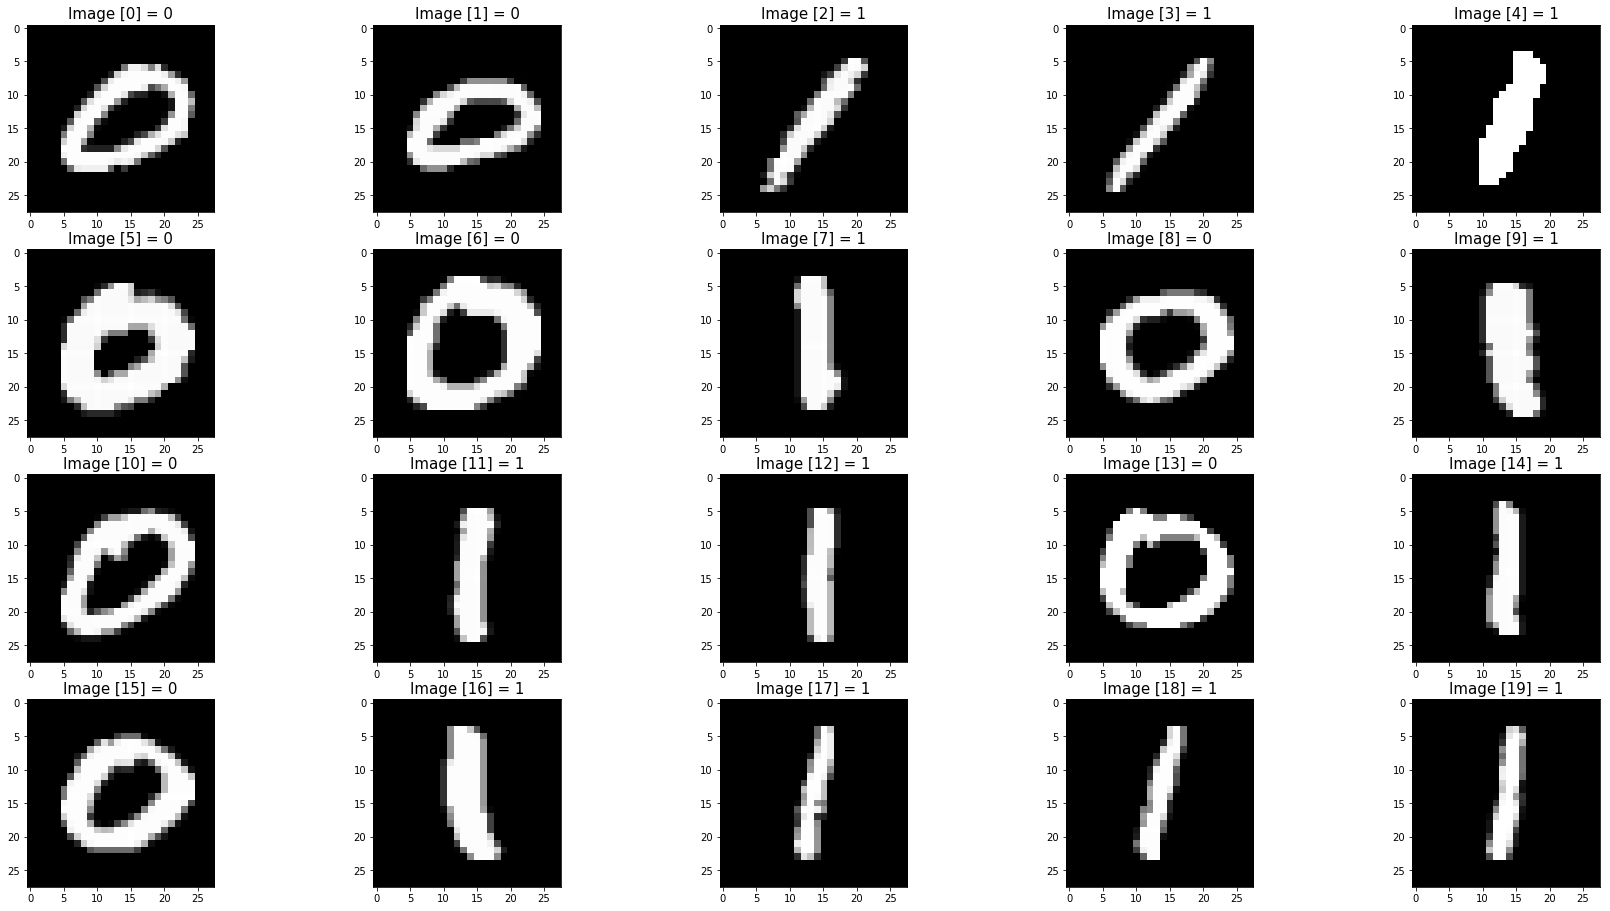

In [10]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [11]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='random', is_target_clustered=1, n_clusters_stepsize=100, targets=[0, 1])

n_clusters_stepsize: 100 is_target_clustered: 1
n_clusters: 100 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 200 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 300 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 400 k-means type: random
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

predicted labels:  [0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0]


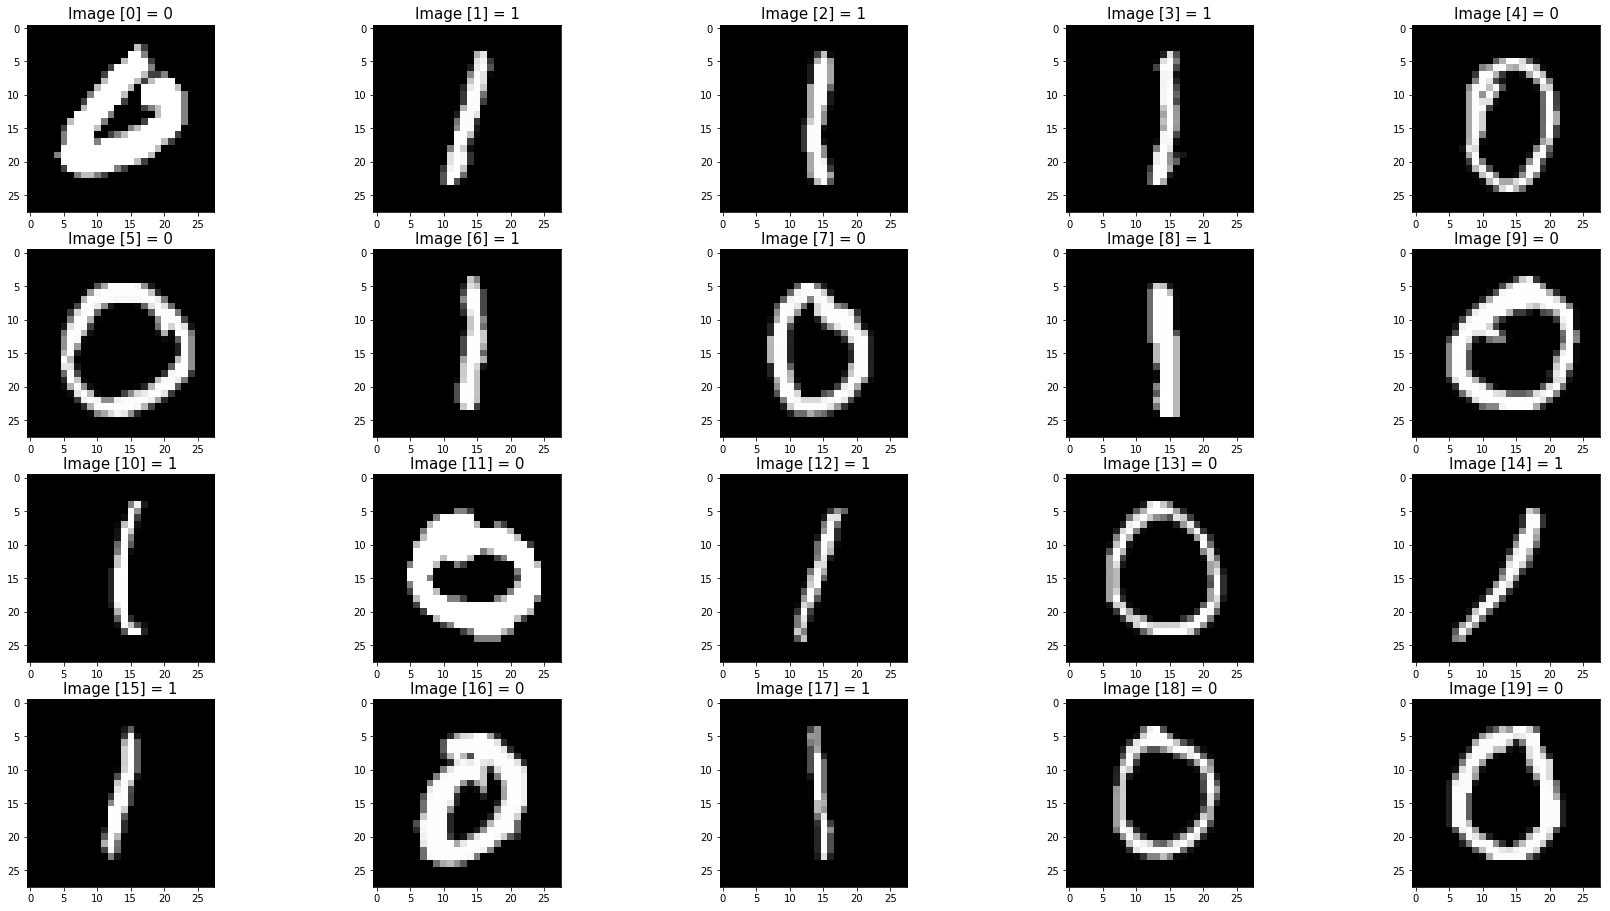

In [12]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [13]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='k-means++', is_target_clustered=0, n_clusters_stepsize=100, targets=[0, 1])

n_clusters_stepsize: 100 is_target_clustered: 0
n_clusters: 100 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 200 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 300 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 400 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.

predicted labels:  [1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1]


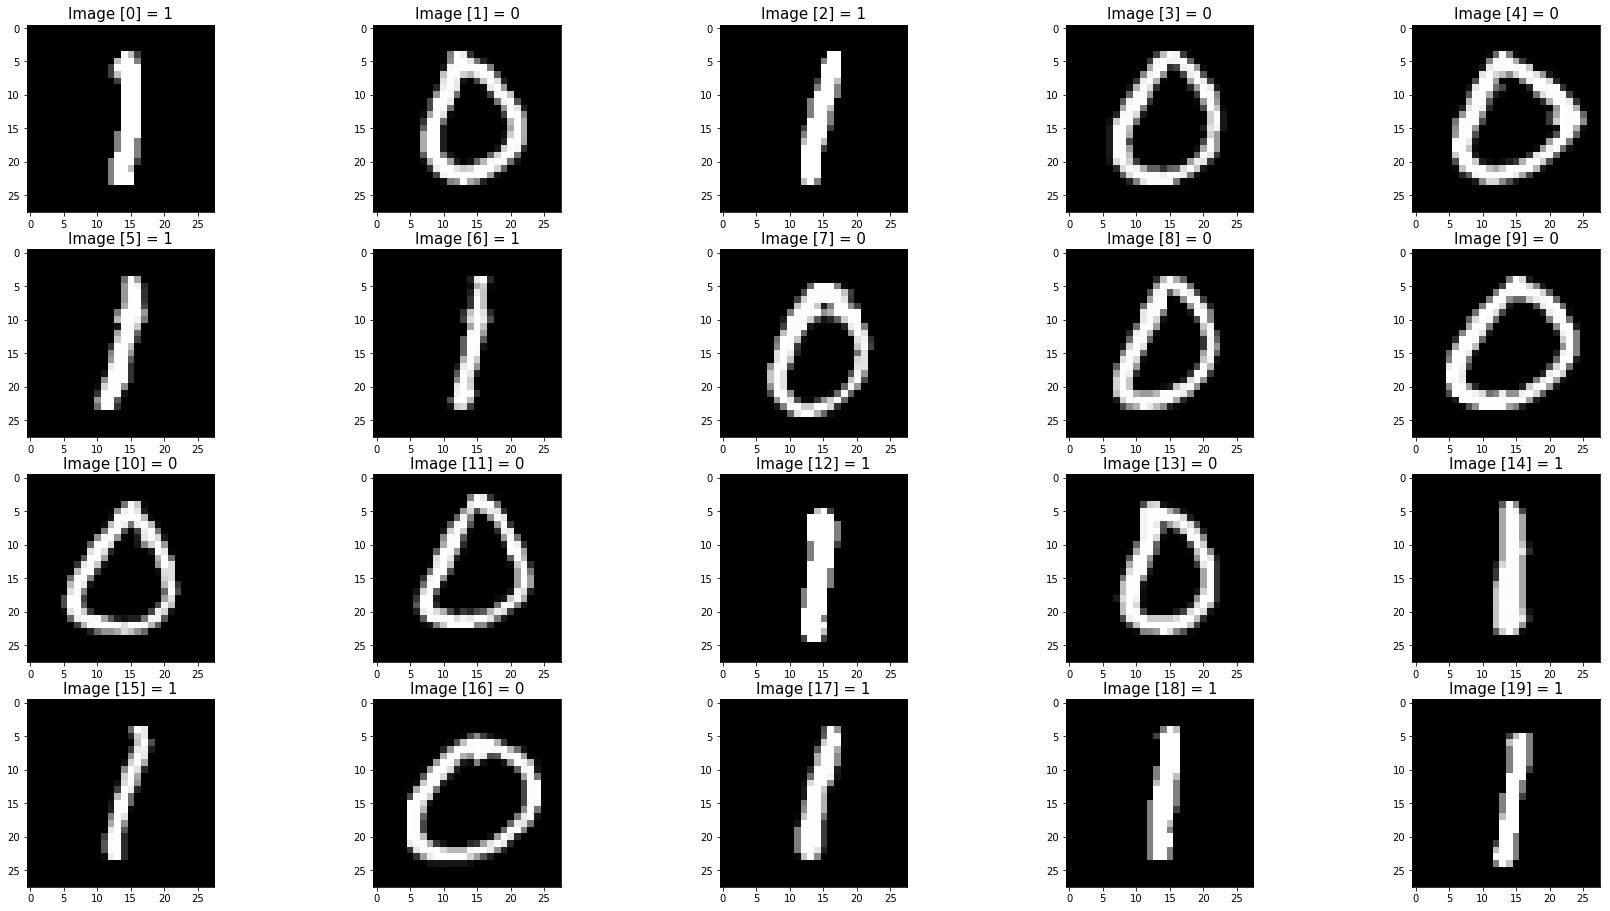

In [14]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [15]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='k-means++', is_target_clustered=1, n_clusters_stepsize=100, targets=[0, 1])

n_clusters_stepsize: 100 is_target_clustered: 1
n_clusters: 100 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 200 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 300 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135

avg / total       1.00      1.00      1.00      2115

n_clusters: 400 k-means type: k-means++
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.

predicted labels:  [1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1]


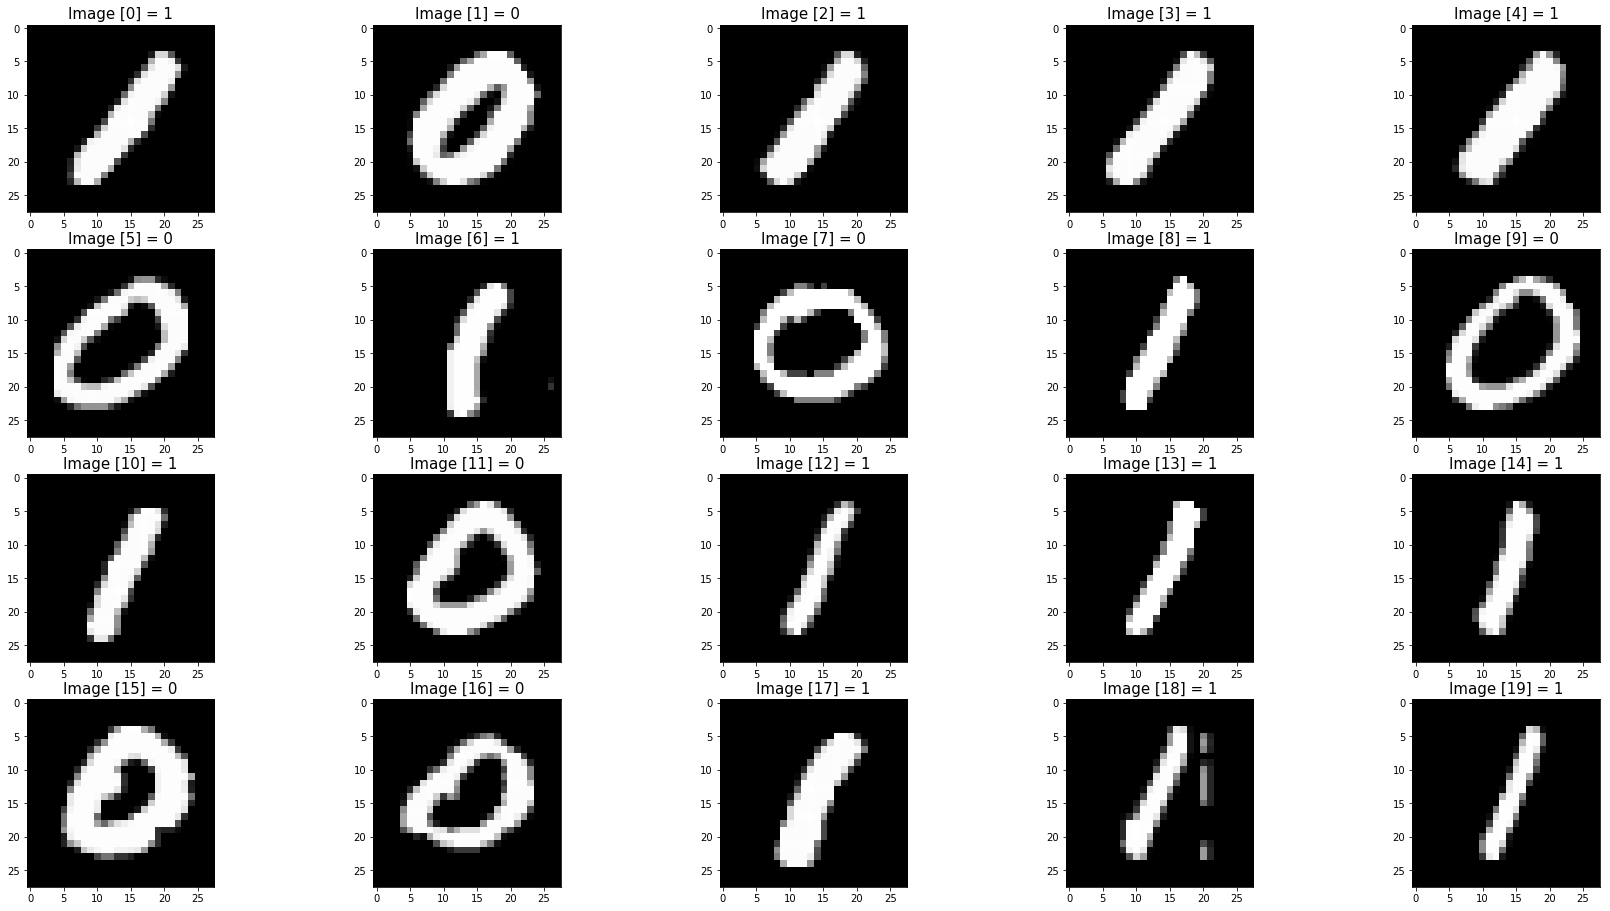

In [16]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [17]:
data_cols_list = []
train_df, test_df, mnist = process_mnist([7, 9])

In [18]:
train_df, test_df, data_cols_list = filter_columns(train_df, test_df, data_cols_list)

In [19]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='random', is_target_clustered=0, n_clusters_stepsize=100, targets=[7, 9])

n_clusters_stepsize: 100 is_target_clustered: 0
n_clusters: 100 k-means type: random
             precision    recall  f1-score   support

          7       0.97      0.97      0.97      1028
          9       0.97      0.97      0.97      1009

avg / total       0.97      0.97      0.97      2037

n_clusters: 200 k-means type: random
             precision    recall  f1-score   support

          7       0.98      0.97      0.98      1028
          9       0.97      0.98      0.98      1009

avg / total       0.98      0.98      0.98      2037

n_clusters: 300 k-means type: random
             precision    recall  f1-score   support

          7       0.98      0.97      0.98      1028
          9       0.97      0.98      0.98      1009

avg / total       0.98      0.98      0.98      2037

n_clusters: 400 k-means type: random
             precision    recall  f1-score   support

          7       0.98      0.98      0.98      1028
          9       0.98      0.98      0.98      1009

predicted labels:  [9 9 7 9 7 9 9 7 9 9 7 7 7 7 7 9 7 9 7 9]


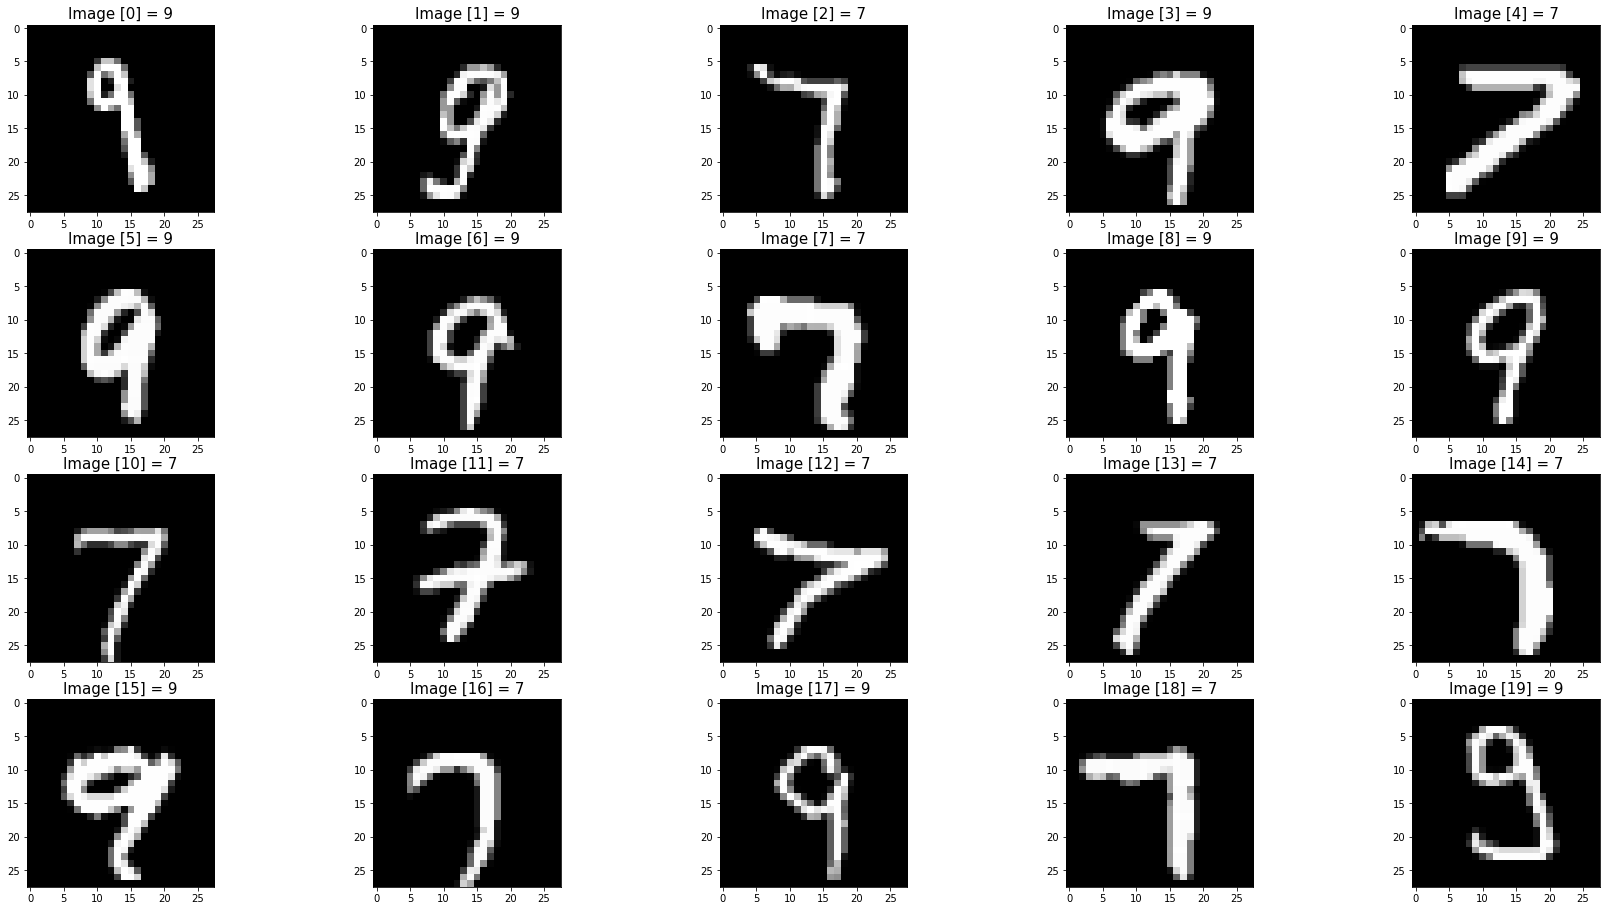

In [20]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [21]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='random', is_target_clustered=1, n_clusters_stepsize=100, targets=[7, 9])

n_clusters_stepsize: 100 is_target_clustered: 1
n_clusters: 100 k-means type: random
             precision    recall  f1-score   support

          7       0.97      0.94      0.96      1028
          9       0.94      0.97      0.96      1009

avg / total       0.96      0.96      0.96      2037

n_clusters: 200 k-means type: random
             precision    recall  f1-score   support

          7       0.96      0.96      0.96      1028
          9       0.96      0.96      0.96      1009

avg / total       0.96      0.96      0.96      2037

n_clusters: 300 k-means type: random
             precision    recall  f1-score   support

          7       0.98      0.96      0.97      1028
          9       0.96      0.98      0.97      1009

avg / total       0.97      0.97      0.97      2037

n_clusters: 400 k-means type: random
             precision    recall  f1-score   support

          7       0.98      0.97      0.97      1028
          9       0.97      0.98      0.97      1009

predicted labels:  [9 9 7 7 7 7 7 7 9 7 9 9 7 9 7 9 9 9 9 9]


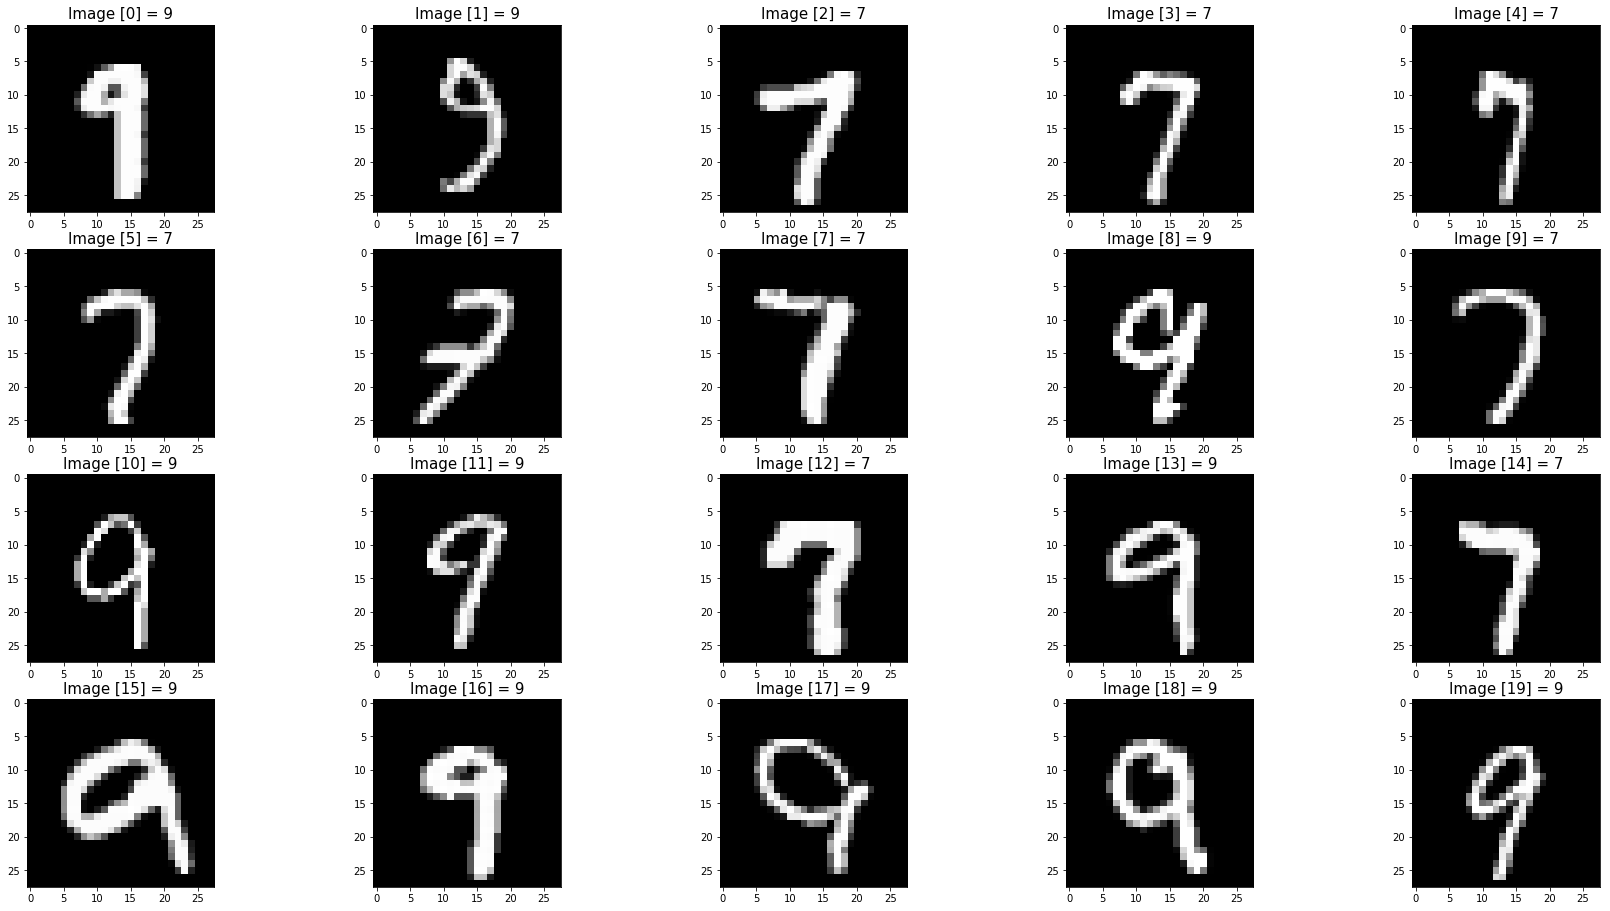

In [22]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [23]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='k-means++', is_target_clustered=0, n_clusters_stepsize=100, targets=[7, 9])

n_clusters_stepsize: 100 is_target_clustered: 0
n_clusters: 100 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.98      0.96      0.97      1028
          9       0.96      0.98      0.97      1009

avg / total       0.97      0.97      0.97      2037

n_clusters: 200 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.98      0.98      0.98      1028
          9       0.98      0.98      0.98      1009

avg / total       0.98      0.98      0.98      2037

n_clusters: 300 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.98      0.97      0.98      1028
          9       0.97      0.98      0.98      1009

avg / total       0.98      0.98      0.98      2037

n_clusters: 400 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.99      0.98      0.98      1028
          9       0.98      0.99      0.

predicted labels:  [7 9 7 9 9 7 7 7 7 9 9 9 9 9 7 9 7 9 7 9]


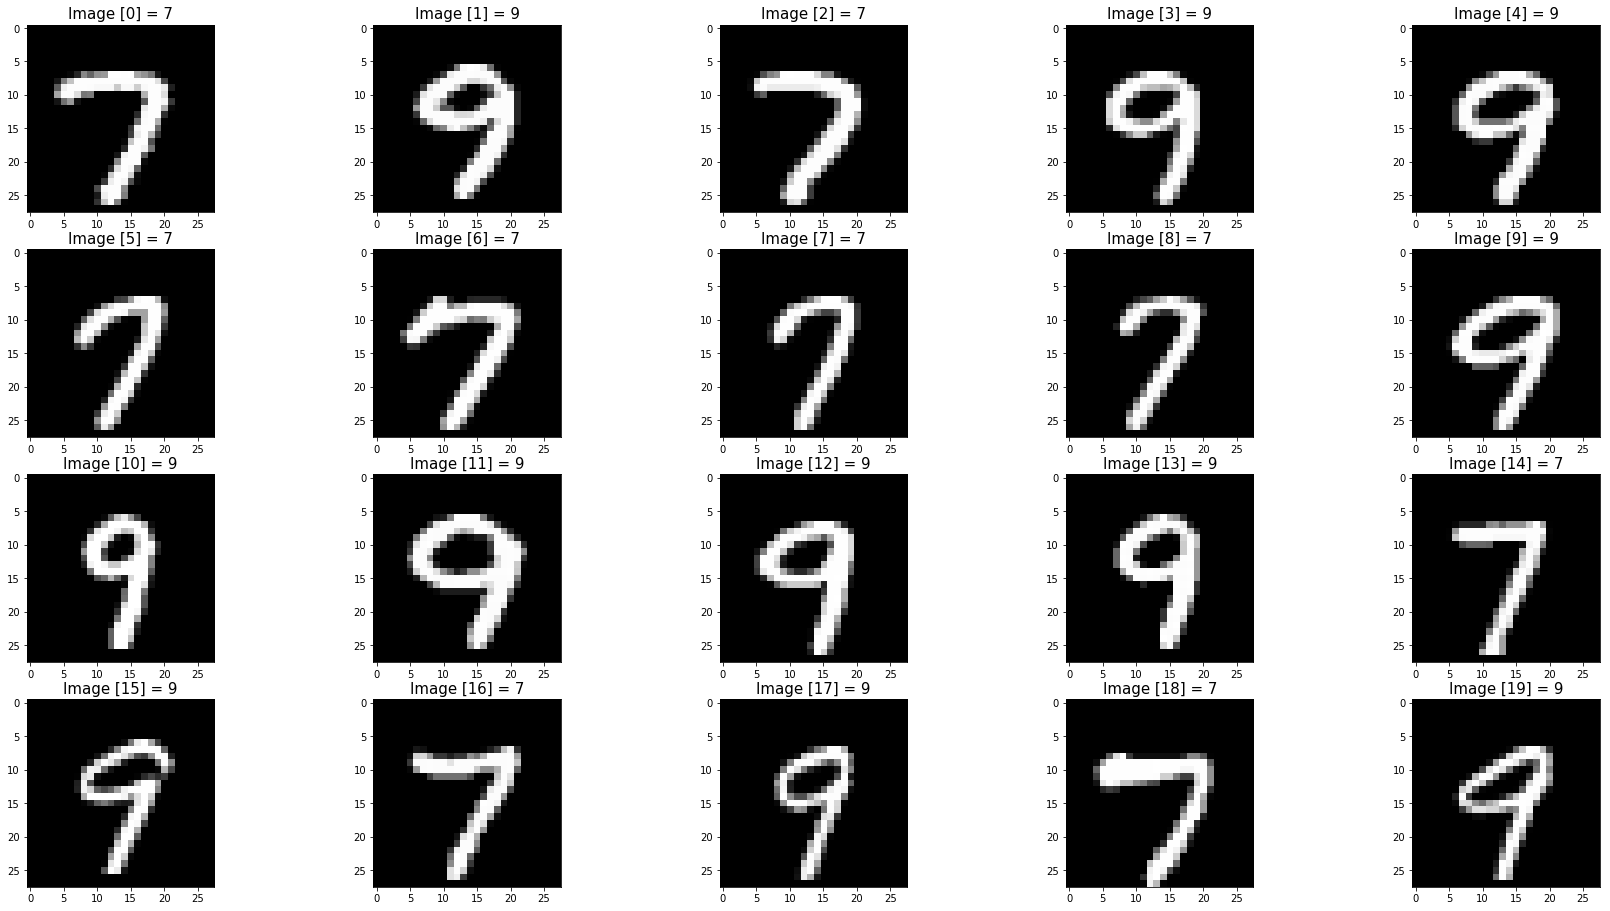

In [24]:
random_sample_test(classifier, mnist, test_df, sample_size=20)

In [25]:
classifier = run_instance_kmeans_knn_classification(train_df, test_df, kmeans_type='k-means++', is_target_clustered=1, n_clusters_stepsize=100, targets=[7, 9])

n_clusters_stepsize: 100 is_target_clustered: 1
n_clusters: 100 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.98      0.94      0.96      1028
          9       0.94      0.98      0.96      1009

avg / total       0.96      0.96      0.96      2037

n_clusters: 200 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.97      0.96      0.96      1028
          9       0.96      0.97      0.96      1009

avg / total       0.96      0.96      0.96      2037

n_clusters: 300 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.98      0.96      0.97      1028
          9       0.96      0.98      0.97      1009

avg / total       0.97      0.97      0.97      2037

n_clusters: 400 k-means type: k-means++
             precision    recall  f1-score   support

          7       0.98      0.96      0.97      1028
          9       0.96      0.98      0.

predicted labels:  [9 7 7 9 7 9 9 9 7 9 7 7 7 7 7 7 9 7 7 9]


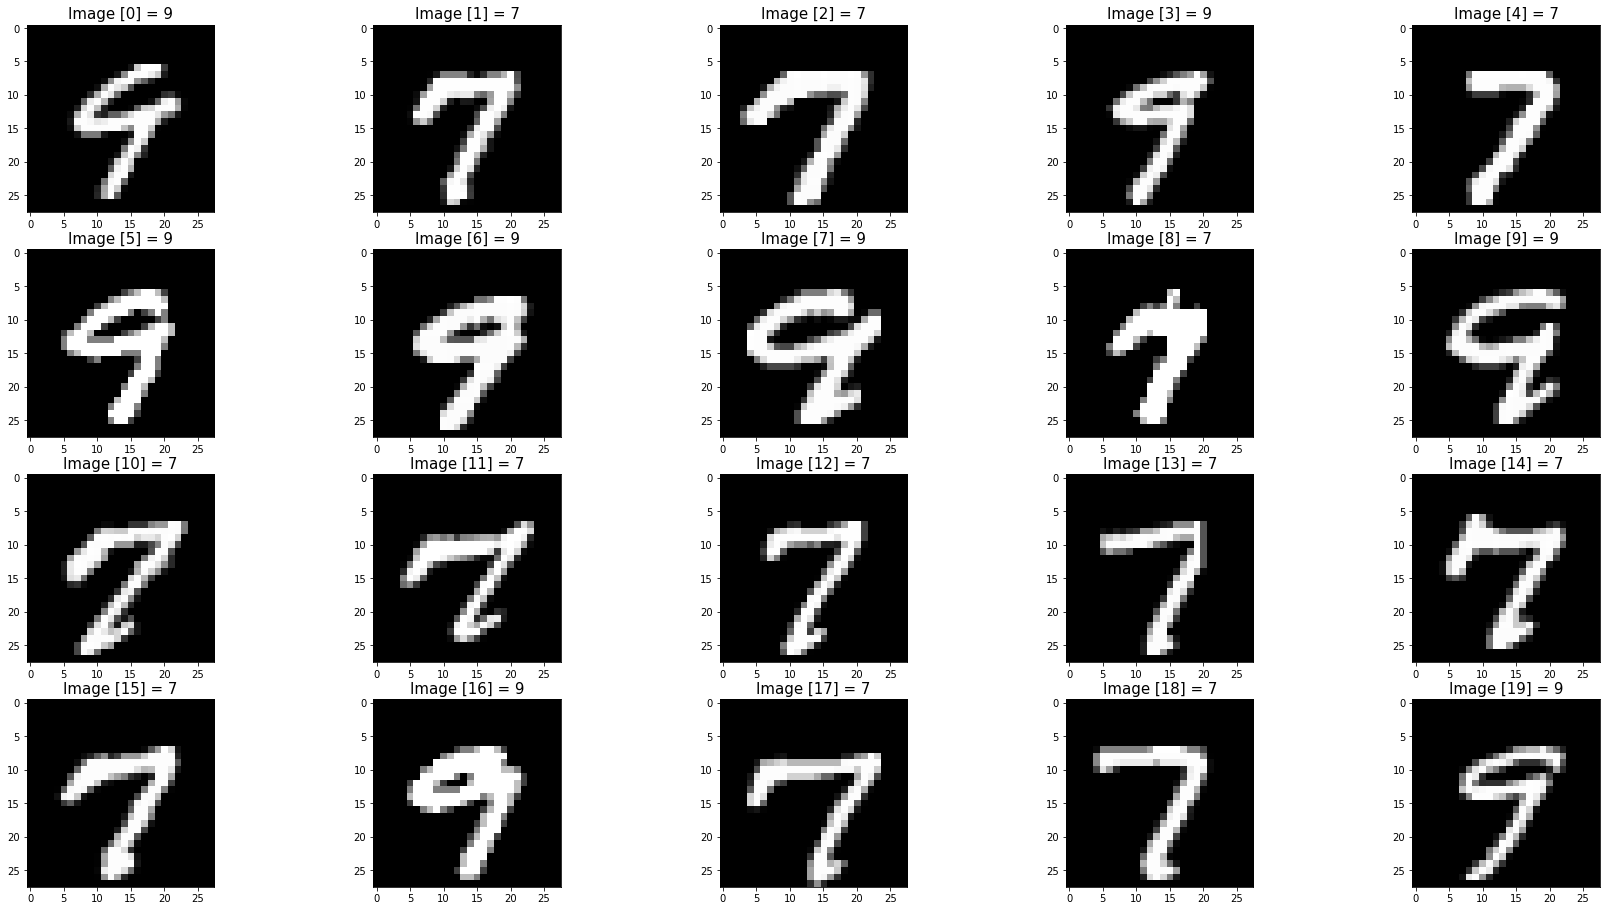

In [26]:
random_sample_test(classifier, mnist, test_df, sample_size=20)